# Latencies

Processes all files found in the given directory containing "wasReceived" and "wasSent".
Considers all wasSent and Received files found in the directory.

In [27]:
# imports
import pandas as pd
import seaborn as sns
import os
import glob
from collections import Counter

# vars
dir = "../logs"

# computed vars
dataDir = os.path.abspath(dir)
output = dataDir + "/"

was_sent = glob.glob(dataDir + "/wasSent*.txt")
was_received = glob.glob(dataDir + "/wasReceived*.txt")

print("Was sent files are {0!s}".format(was_sent))
print("Was received files are {0!s}".format(was_received))
print("Writing result to " + output)

# Configure seaborn
sns.set()
print("seaborn configured")  

Was sent files are ['/Users/jonathanhasenburg/git/GeoBrokerExample/logs/wasSent_client1.txt', '/Users/jonathanhasenburg/git/GeoBrokerExample/logs/wasSent_client2.txt']
Was received files are ['/Users/jonathanhasenburg/git/GeoBrokerExample/logs/wasReceived_client2.txt', '/Users/jonathanhasenburg/git/GeoBrokerExample/logs/wasReceived_client1.txt']
Writing result to /Users/jonathanhasenburg/git/GeoBrokerExample/logs/
seaborn configured


In [28]:
# fill published messages

was_sent_lines = []
published_messages = {}
# read in file contents
for path in was_sent:
    with open(path) as f:
        lines = f.readlines()
        lines.pop(0) # header
        was_sent_lines = was_sent_lines + lines
    
for line in was_sent_lines:
    line = line.replace("\n", "")
    split = line.split("	") # 2 parts, timestamp and payload
    
    if "PUBLISHPayload" in split[1]: # this is a publish message
        message_id = split[1].split(", content=")[1].replace("))", "")
        published_messages[message_id] = int(split[0])

print("Parsed sent messages, there were {0!s} published messages".format(len(published_messages)))

Parsed sent messages, there were 6212 published messages


In [29]:
# run through received messages and fill rows

rows = []
was_received_lines = []

# read in file contents
for path in was_received:
    with open(path) as f:
        lines = f.readlines()
        lines.pop(0) # header
        was_received_lines = was_received_lines + lines
    
for line in was_received_lines:
    row = {}
    line = line.replace("\n", "")
    split = line.split("	")
    
    if "PUBLISHPayload" in split[1]:
        message_id = split[1].split(", content=")[1].replace("))", "")
        sent_timestamp = published_messages[message_id]
        row["message_id"] = message_id
        row["receiver"] = split[1].split(",")[0][1:]
        row["sent_timestamp"] = sent_timestamp
        row["latency"] = int(split[0]) - sent_timestamp
        rows.append(row)
        
print("Parsed {0!s} received publish messages".format(len(rows)))

Parsed 7956 received publish messages


In [30]:
df = pd.DataFrame(rows)
# use experiment time for sent_timestamps
first = df["sent_timestamp"].min()
df["sent_timestamp"] = df["sent_timestamp"] - first
# sort
df.sort_values(by = "sent_timestamp", inplace = True)
df.head()

,message_id,receiver,sent_timestamp,latency
1,Columbus-1_small-bush-9659_5_text/0_,Columbus-1_small-bush-9659,0,31
11,Columbus-1_old-hall-9141_5_text/0_,Columbus-1_old-hall-9141,0,47
4084,Columbus-1_fancy-glitter-0008_5_text/0_,Columbus-0_fancy-bush-0176,1,28
4085,Columbus-1_fancy-glitter-0008_5_text/0_,Columbus-0_throbbing-dust-9693,1,28
9,Columbus-1_fancy-glitter-0008_5_text/0_,Columbus-1_fancy-glitter-0008,1,45


In [31]:
# describe latencies
df["latency"].describe()

count    7956.000000
mean       16.680870
std         6.924798
min         7.000000
25%        11.000000
50%        16.000000
75%        21.000000
max       154.000000
Name: latency, dtype: float64

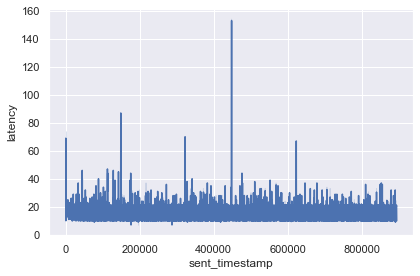

In [32]:
# plot
tmp = df # .drop(columns=["receiver"])
ax = sns.lineplot(data=tmp, x="sent_timestamp", y="latency")
fig = ax.get_figure()
fig.tight_layout()
fig.savefig(output + "latencies.pdf")

In [33]:
# Calculate cumulative distribution
cum_df = pd.DataFrame()

# create dataframe with counts per latency
df_tmp = pd.DataFrame(dict(Counter(df["latency"])), index=[0]).T
# transform index into column and add other columns needed for the figure
df_tmp.reset_index(inplace=True)
df_tmp.columns = ["Latency [ms]", "Count"]
# calculate distribution
df_tmp.sort_values(by="Latency [ms]", inplace=True)
df_tmp["cumsum"] = df_tmp["Count"].cumsum()
sum = df_tmp["Count"].sum()
df_tmp["Cumulative Distribution"] = df_tmp["cumsum"] / sum
# add to result cum_df
cum_df = cum_df.append(df_tmp)

# Print out to check whether looks good
cum_df.sort_values(by="Latency [ms]", inplace=True)
cum_df.reset_index(inplace=True, drop=True) # optionally reset index
cum_df.head(100)

,Latency [ms],Count,cumsum,Cumulative Distribution
0,7,3,3,0.000377
1,9,5,8,0.001006
2,10,1400,1408,0.176973
3,11,1735,3143,0.395048
4,12,87,3230,0.405983
...,...,...,...,...
58,70,2,7952,0.999497
59,74,1,7953,0.999623
60,87,1,7954,0.999749
61,152,1,7955,0.999874


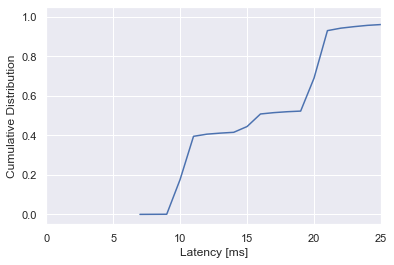

In [34]:
ax = sns.lineplot(x="Latency [ms]", y="Cumulative Distribution", data=cum_df)
ax.set_xlim(0, 25)
ax.get_figure().savefig(output + "/cum.pdf")

In [35]:
# Calculate cumulative distribution for each receiving client
clientCum_df = pd.DataFrame()

for receiver in df["receiver"].unique():
    receiver_df = df[df["receiver"] == receiver]
    # create dataframe with counts per latency
    df_tmp = pd.DataFrame(dict(Counter(receiver_df["latency"])), index=[0]).T
    # transform index into column and add other columns needed for the figure
    df_tmp.reset_index(inplace=True)
    df_tmp.insert(0, "a", receiver)
    df_tmp.columns = ["Receiver", "Latency [ms]", "Count"]
    # calculate distribution
    df_tmp.sort_values(by="Latency [ms]", inplace=True)
    df_tmp["cumsum"] = df_tmp["Count"].cumsum()
    sum = df_tmp["Count"].sum()
    df_tmp["Cumulative Distribution"] = df_tmp["cumsum"] / sum
    # add to result df
    clientCum_df = clientCum_df.append(df_tmp)
    
# Print out to check whether looks good
clientCum_df.sort_values(by="Latency [ms]", inplace=True)
clientCum_df.reset_index(inplace=True, drop=True) # optionally reset index
clientCum_df.head(100)

,Receiver,Latency [ms],Count,cumsum,Cumulative Distribution
0,Columbus-0_wispy-heart-0689,7,1,1,0.019608
1,Columbus-0_late-shadow-2704,7,1,1,0.024390
2,Columbus-0_silent-dream-5831,7,1,1,0.040000
3,Columbus-0_broken-disk-1344,9,1,1,0.031250
4,Columbus-0_young-pond-5686,9,1,1,0.018868
...,...,...,...,...,...
95,Columbus-0_white-hill-1935,10,10,10,0.322581
96,Columbus-0_silent-dream-5831,10,8,9,0.360000
97,Columbus-0_hidden-limit-7229,10,15,15,0.300000
98,Columbus-0_shrill-snowflake-4949,10,14,14,0.451613


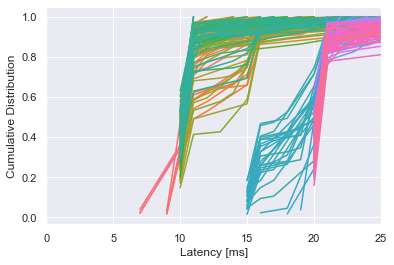

In [36]:
ax = sns.lineplot(x="Latency [ms]", y="Cumulative Distribution", hue="Receiver", data=clientCum_df, legend=False)
ax.set_xlim(0, 25)
ax.get_figure().savefig(output + "/clientCum.pdf")